<a href="https://www.kaggle.com/code/aisuko/multi-class-prediction?scriptVersionId=166235795" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

In this notebook, we will do some data visualization work and prepare the data to what we need to. After that, we will use pycaret to pick iup the best accuracy model to solve this question.

In [4]:
%%capture
!pip install pycaret==3.3.0

In [5]:
import os
import pandas as pd
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

warnings.filterwarnings('ignore')

# Loading and Checking the Dataset

In [6]:
train=pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col='id')
test=pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col='id')
submission=pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [7]:
train.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000,20758.000,20758.000,20758.000,20758.000,20758.000,20758.000,20758.000,20758.000
mean,10378.500,23.842,1.700,87.888,2.446,2.761,2.029,0.982,0.617
std,5992.463,5.688,0.087,26.379,0.533,0.705,0.608,0.838,0.602
min,0.000,14.000,1.450,39.000,1.000,1.000,1.000,0.000,0.000
25%,5189.250,20.000,1.632,66.000,2.000,3.000,1.792,0.008,0.000
50%,10378.500,22.815,1.700,84.065,2.394,3.000,2.000,1.000,0.574
75%,15567.750,26.000,1.763,111.601,3.000,3.000,2.550,1.587,1.000
max,20757.000,61.000,1.976,165.057,3.000,4.000,3.000,3.000,2.000


In [8]:
def check_df(df):
    print("############# Shape #############")
    print(df.shape)
    print("############# Types #############")
    print(df.dtypes)
    print("############# NA #############")
    print(df.isnull().sum())
    print("############# Quantiles #############")
    numeric_columns=df.select_dtypes(include=['number']).columns
    # return values at the given quantile over requested axis
    print(df[numeric_columns].quantile([0,0.05,0.50,0.95,0.99], 1).T)
    

check_df(train)

############# Shape #############
(20758, 18)
############# Types #############
id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object
############# NA #############
id                                0
Gender                            0
Age                               0
Height     

In [9]:
train.head().T

,0,1,2,3,4
id,0,1,2,3,4
Gender,Male,Female,Female,Female,Male
Age,24.443,18.000,18.000,20.953,31.641
Height,1.700,1.560,1.711,1.711,1.914
Weight,81.670,57.000,50.166,131.275,93.798
family_history_with_overweight,yes,yes,yes,yes,yes
FAVC,yes,yes,yes,yes,yes
FCVC,2.000,2.000,1.881,3.000,2.680
NCP,2.983,3.000,1.412,3.000,1.971
CAEC,Sometimes,Frequently,Sometimes,Sometimes,Sometimes


# Visualization Data

We are more familiar the every attribute of data that will make our model performance more stable. Here we represent the situation with a plot, ordering the classes based on overweight.

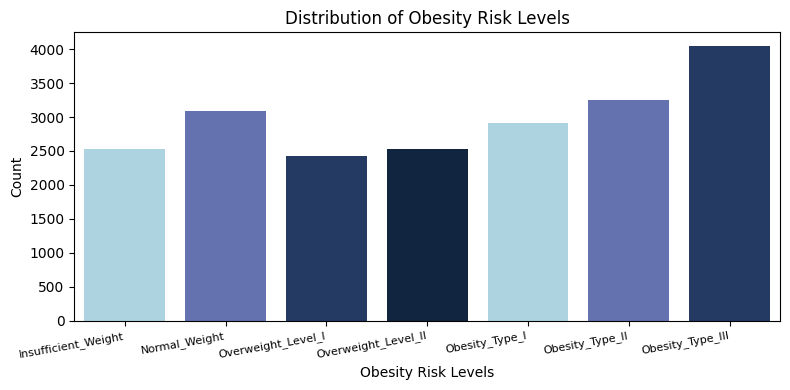

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

target=train["NObeyesdad"]
color_list=["#A5D7E8", "#576CBC", "#19376D", "#0B2447"]
cmap_custom=ListedColormap(color_list)

sorted_labels = ['Insufficient_Weight', 'Normal_Weight', 
 'Overweight_Level_I', 'Overweight_Level_II', 
 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

plt.figure(figsize=(8,4))
ax=sns.countplot(x=target, order=sorted_labels, palette=color_list)

plt.title('Distribution of Obesity Risk Levels')
plt.xlabel('Obesity Risk Levels')
plt.ylabel('Count')

ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

# Modelling Data

We convert the target, expresses by string labels into numeric labels, using a custom implementation of Scikit-learn LabelEncoder that orders the encoded label based on the order we proposed before.

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, sorted_labels):
        self.classes_=sorted_labels
        self.label_to_numeric_mapping=None
        
    def fit(self, y):
        self.label_to_numeric_mapping={label:numeric for numeric, label in enumerate(self.classes_)}
        return self
    
    def transform(self, y):
        if self.label_to_numeric_mapping is None:
            raise ValueError("Fit method must be called before transform")
        return y.map(self.label_to_numeric_mapping)
    
    def inverse_transform(self, y):
        if self.label_to_numeric_mapping is None:
            raise ValueError("Fit method must be called before inverse_transform")
        return pd.Series(y).map({numeric: label for label, numeric in self.label_to_numeric_mapping.items()})

target_encoder=CustomLabelEncoder(sorted_labels)
target_encoder.fit(target)
target_numeric=target_encoder.transform(target)
target_numeric

0        3
1        1
2        0
3        6
4        3
        ..
20753    5
20754    0
20755    5
20756    3
20757    5
Name: NObeyesdad, Length: 20758, dtype: int64

# Spliting Object and Numberic Data

In [12]:
categorical_features=train.columns[train.dtypes=="object"].tolist()
numeric_features=train.columns[train.dtypes!="object"].tolist()

## One-Hot-Encoding

All the categorical features have very few unique levels, making one-hot-encoding the best choice for this situation.

In [13]:
train[categorical_features].nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              3
MTRANS                            5
NObeyesdad                        7
dtype: int64

## Continuous Values

All the numeric features, have enough distinct values to confirm their are continuous ones.

In [14]:
train[numeric_features].nunique()

id        20758
Age        1703
Height     1833
Weight     1979
FCVC        934
NCP         689
CH2O       1506
FAF        1360
TUE        1297
dtype: int64

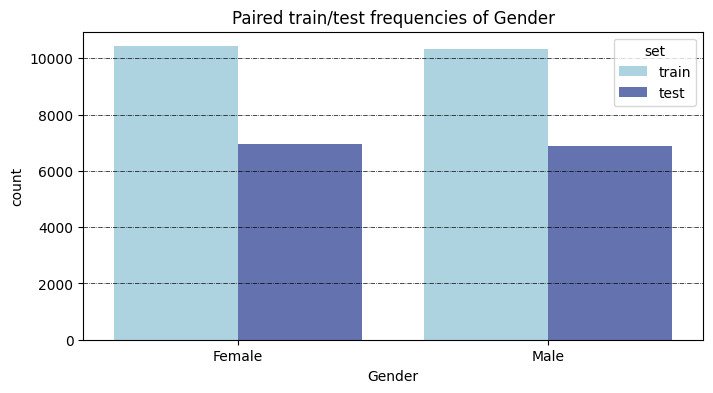

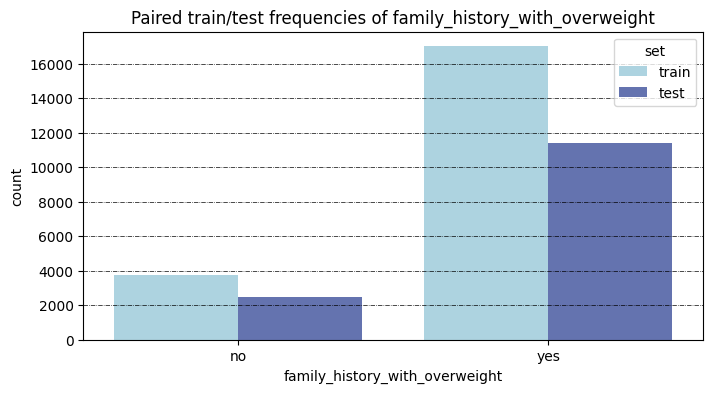

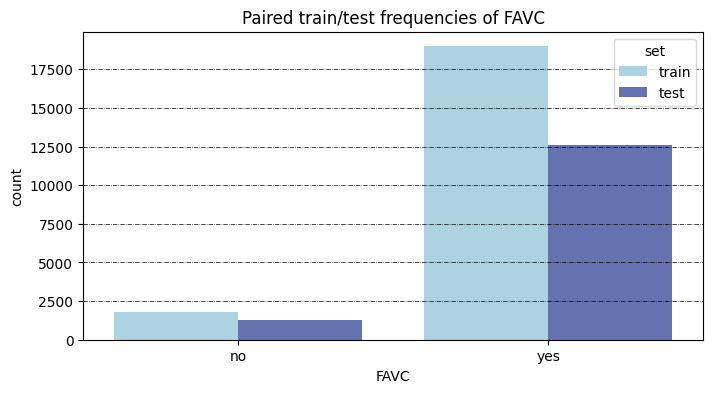

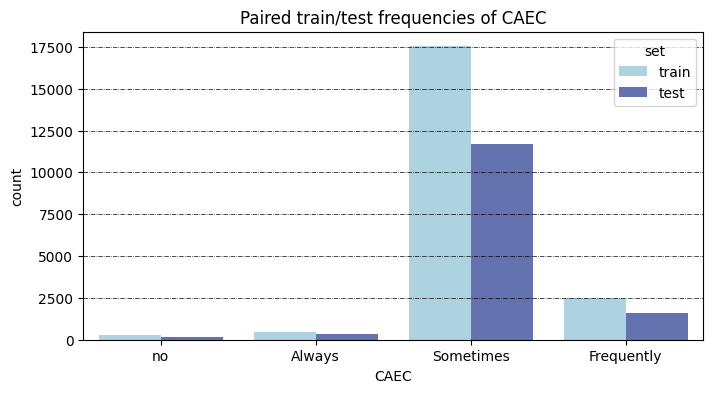

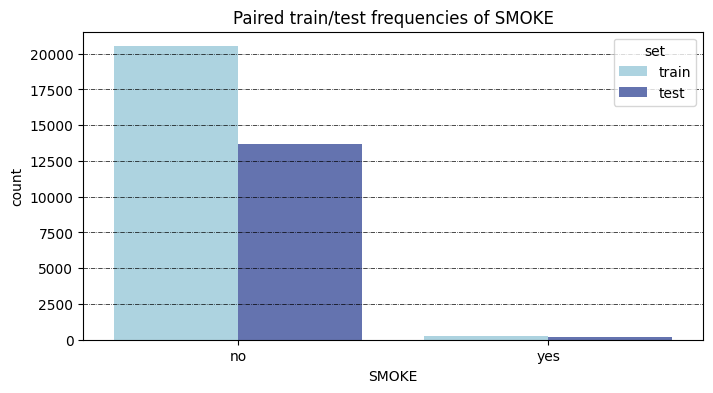

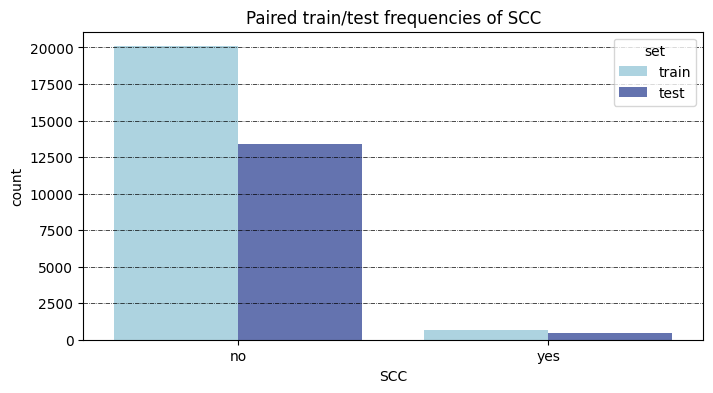

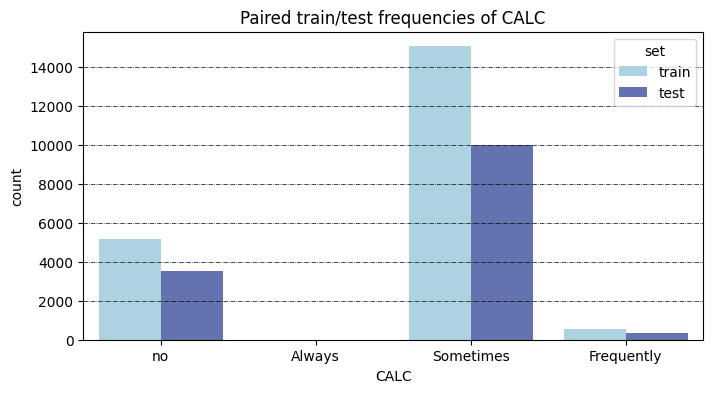

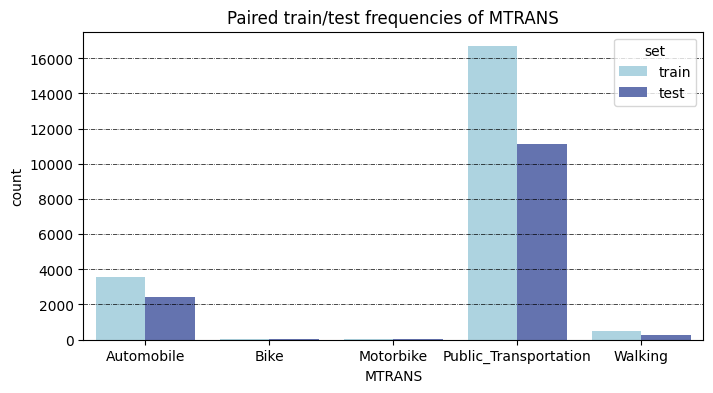

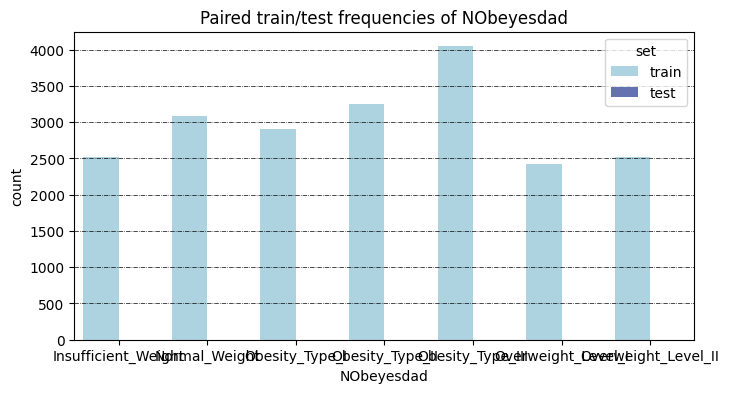

In [15]:
def plot_count_pairs(train, test, feature, hue="set", order=None, palette=None):
    data_df=train.copy()
    data_df['set']='train'
    data_df=pd.concat([data_df, test.copy()]).fillna('test')
    f,ax=plt.subplots(1,1,figsize=(8,4))
    sns.countplot(x=feature, data=data_df, hue=hue, palette=color_list, order=order)
    plt.grid(color="black", linestyle="-.", linewidth=0.5, axis="y", which="major")
    ax.set_title(f"Paired train/test frequencies of {feature}")
    plt.show()

for feature in categorical_features:
    if feature in ["CAEC", "CALC"]:
        order=["no", "Always", "Sometimes", "Frequently"]
    else:
        order=sorted(train[feature].unique())
    plot_count_pairs(train, test, feature=feature, order=order, palette=color_list)

# Setting up a Target

In [16]:
from pycaret.classification import setup

sp=setup(train, target='NObeyesdad', experiment_name='obesity_prediction', session_id=2024)
sp

,Description,Value
0,Session id,2024
1,Target,NObeyesdad
2,Target type,Multiclass
3,Target mapping,"Insufficient_Weight: 0, Normal_Weight: 1, Obesity_Type_I: 2, Obesity_Type_II: 3, Obesity_Type_III: 4, Overweight_Level_I: 5, Overweight_Level_II: 6"
4,Original data shape,"(20758, 18)"
5,Transformed data shape,"(20758, 27)"
6,Transformed train set shape,"(14530, 27)"
7,Transformed test set shape,"(6228, 27)"
8,Numeric features,9
9,Categorical features,8


# Comparing the Model Accuracy

In [17]:
from pycaret.classification import compare_models

best=compare_models(n_select=1)
best

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:53:10
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8962,0.0000,0.8962,0.8965,0.8957,0.8782,0.8784,2.3540
dt,Decision Tree Classifier,0.8498,0.0000,0.8498,0.8500,0.8496,0.8238,0.8239,0.4160
qda,Quadratic Discriminant Analysis,0.6893,0.0000,0.6893,0.6984,0.6675,0.6352,0.6478,0.2900
nb,Naive Bayes,0.6765,0.0000,0.6765,0.6821,0.6607,0.6195,0.6264,0.2950
ridge,Ridge Classifier,0.6368,0.0000,0.6368,0.6262,0.6004,0.5715,0.5796,0.2810
knn,K Neighbors Classifier,0.4278,0.0000,0.4278,0.4249,0.4233,0.3283,0.3291,0.3610
ada,Ada Boost Classifier,0.4087,0.0000,0.4087,0.3057,0.2888,0.3108,0.3442,1.0650
lr,Logistic Regression,0.3862,0.0000,0.3862,0.3750,0.3560,0.2738,0.2784,1.6950
svm,SVM - Linear Kernel,0.1778,0.0000,0.1778,0.1909,0.0922,0.0413,0.0709,2.1200


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Training Model

In [ ]:
from pycaret.classification import finalize_model, predict_model

# This function trains a given model on the entire dataset including the hold-out set.
finalized_model=finalize_model(best)

#This function generates the label using a trained model.  When data is None, it predicts label and score on the holdout set. 
predict_model(finalized_model)

# Visualization Features

In [ ]:
from pycaret.classification import plot_model

#This function analyzes the performance of a trained model on the hold-out set. It may require re-training the model in certain cases.
plot_model(finalized_model, plot='feature')

# Making Predictions

In [ ]:
preditions=predict_model(finalized_model, data=test, raw_score=True)
preditions.head().T

# Submission

In [ ]:
submission=pd.DataFrame({'id':test.index, 'NObeyesdad':preditions['prediction_label']})
submission.to_csv("submission.csv", index=False)
submission.head()

In [ ]:
submission.tail()

In [ ]:
submission.shape()

# Acknowledge

* https://www.kaggle.com/code/muzammilbaloch/automl-and-obesity-risk-outcomes
* https://www.kaggle.com/code/lucamassaron/easy-peasy-eda-xgboost-is-all-you-need